In [886]:
# MODEL PARAMETERS

# Adjust model params here
num_runs = 5 # Number of times to run simulation
event_length = 7 
baseline_beta = 1
mitigation_beta = 1
prevalence = .03
prop_natural_immune = .253
pop = 10000
event_environment = "mixed" # "outdoor", "indoor", or "mixed"

# Booleans for choice of intervention
use_vaccines = False
use_vaccines_baseline = False
use_testing = False
use_base_beta = False # Apply beta to baseline (temp for debugging)
use_mit_beta = False # Apply beta to comparison event ^^

# Testing params
test_del = 0 # Test delay (days)
days_testing = 0 # Number of days performing tests susceptibles
subtarg = None # Subtargetting of tests
sens = .984 # Sensitivity of test used
use_rapid = True # True for onsite rapid tests, False for reported tests
test_window = 4 # e.g if 2, negative test from <2 days prior to event required. Max 4

# Vaccine params
perc_vax = .2 # Percentage of population vaxxed
passport = True # True if 100% of attendees must be vaccinated
v_efficacy_inf = .1 # Vax efficacy against infection (e.g .2 == 80% efficacy)
v_efficacy_symp = .06 # Vax efficacy against symptoms

#NPIs
mask_wearing = True
capacity_limits = True
improved_ventilation = False

# Biological characteristics
use_natural_immunity = True
n_efficacy_inf = .3 # Natural immunity efficacy against infection
n_efficacy_symp = .2 # Natural immunity efficacy against symptoms
use_variant = True
voc_transmissibility = 1.67 # Increased transmissibility due to variant of concern
voc_prevalence = .9 # Proportion of variant with increased transmissibility

# Point estimates
indoor_factor = 9.35
outdoor_factor = .11 
mask_factor = .56
ventilation_factor = .69
capacity_factor = .5



In [887]:
# IMPORTS
import covasim as cv
from datetime import date, timedelta
cv.options.set(dpi=100, font_size=9)

In [888]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

In [889]:

# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die? Or add 30 days to simulation?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length))

# Initialize model parameters
pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop,
    pop_infected = pop * prevalence
)

""" test_intervention: Creates intervention for a testing strategy
-   test_del: Delay in test result
-   days_testing: Number of days in event testing susceptibles
-   subtarg: Indices of population to subtarget
-   sens: Sensitivity of test used
"""
# Note: this only works for cases generated at event. 
# For single entry testing only, run test_intervention(0,0)
def test_intervention(test_del, days_testing, subtarg=None, sens=sens, rapid=True, window=2):

    if (rapid):
        pars['pop_infected'] -= sens * pars['pop_infected']
    else:
       # Newly infected are those infected after test (assume even distribution of test date from 1 to 'window' days ago)
       # Assume 12 days infectious, all tests within 4.6 day period from exposed->infectious (max window 4)
       # These people will test negative even with a perfect test, because they were exposed after testing negative
       
       num_preinfectious = prevalence * pop * sum([x*(1/(12*window)) for x in range(1,window+1)])

       # Finally, remove population that is detected by the reported tests
       pars['pop_infected'] += num_preinfectious - sens * pars['pop_infected']
    
    return cv.test_num(daily_tests=[pop]*days_testing, 
                       start_day=d1, 
                       subtarget=subtarg,
                       symp_test=0,
                       sensitivity=sens,
                       test_delay=test_del)

"""vaccine_intervention: Creates intervention for a vaccine-based entry strategy
- percent_vax: Percentage of overall population vaccinated
- passport: If true, 100% of attendees must be vaccinated
- efficacy_inf: Efficacy against infection
- efficacy_symp: Efficacy against symptoms
- Returns intervention 
"""
def vaccine_intervention(percent_vax, passport = False, efficacy_inf = v_efficacy_inf, efficacy_symp = v_efficacy_symp):
    pars['pop_infected'] -= (1-efficacy_inf) * percent_vax * pars['pop_infected']
    if passport:
        percent_vax = 1
    return cv.vaccine(days=0, prob=percent_vax, rel_sus=efficacy_inf, rel_symp=efficacy_symp)






In [890]:
## FUNCTIONS FOR PRODUCING COMBINED VISUALIZAITONS
def sweep_prevalence(prevalences, interventions, descr):
    msims = []
    old_prev = pars['pop_infected']
    for p in prevalences:
        new_descr = descr + f'prevalence = {p}'
        pars['pop_infected'] = p * pop
        sims = []
        for i in range(num_runs):
            sim = cv.Sim(pars, interventions=interventions, rand_seed=i, label=new_descr)
            sims.append(sim)
        msim = cv.MultiSim(sims)
        msim.run()
        msim.mean()
        msims.append(msim)
        pars['pop_infected'] = old_prev
    return msims

def all_testing_strategies(interventions):
    msims = []
    old_prev = pars['pop_infected']
    for strat in [(0,0,True,0, "Entry antigen"), (0,7,True,0, "Daily antigen"),(0,0,False,2, "PCR 2-day"),(0,0,False,4, "PCR 4-day")]:
        # Entry antigen testing, one time
        sims = []
        for i in range(num_runs):
            int = test_intervention(test_del=strat[0], days_testing=strat[1], sens=sens, rapid=strat[2], window=strat[3])
            sim = cv.Sim(pars, interventions=interventions + [int], rand_seed=i, label=strat[4])
            sims.append(sim)
            pars['pop_infected'] = old_prev # Because testing makes pop_infected go down, we must reset on every simulation

        msim = cv.MultiSim(sims)
        msim.run()
        msim.mean()
        msims.append(msim)
    return msims

def sweep_vaccines(proportions, interventions):
    msims = []
    old_prev = pars['pop_infected']
    for p in proportions:
        sims = []
        for i in range(num_runs):
            vax = vaccine_intervention(p, False, v_efficacy_inf, v_efficacy_symp)
            sim = cv.Sim(pars, interventions=interventions + [vax], rand_seed=i, label=f'{p*100}% vaccinated')
            sims.append(sim)
            pars['pop_infected'] = old_prev
        msim = cv.MultiSim(sims)
        msim.run()
        msim.mean()
        msims.append(msim)
    return msims 

In [891]:
# INTERVENTIONS AND SIMULATIONS

# Shared interventions
all_msims = []
shared_interventions = []
end_of_event = cv.change_beta(days=[d2], changes=[0]) # Transmission stops after event ends
shared_interventions.append(end_of_event)

if (use_natural_immunity):
    natural_immunity = vaccine_intervention(prop_natural_immune, False, n_efficacy_inf, n_efficacy_symp)
    shared_interventions.append(natural_immunity)
if (use_variant):
    voc = cv.change_beta(d1, voc_transmissibility * voc_prevalence)
    shared_interventions.append(voc)
# Mixed is the baseline
if (event_environment == "indoor"):
    environment = cv.change_beta(d1, indoor_factor)
    shared_interventions.append(environment)

elif (event_environment == "outdoor"):
    environment = cv.change_beta(d1, outdoor_factor)
    shared_interventions.append(environment)

# Baseline interventions and simulation
base_interventions = [] + shared_interventions

if (use_base_beta):
    event_baseline = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[baseline_beta]*(event_length)))
    base_interventions.append(event_baseline)

if (use_vaccines_baseline):
    vaccine_baseline = vaccine_intervention(perc_vax, False, v_efficacy_inf, v_efficacy_symp)
    base_interventions.append(vaccine_baseline)


orig_sim = cv.Sim(pars, interventions=base_interventions, label='Baseline')
msim2 = cv.MultiSim(orig_sim)
msim2.run(n_runs=num_runs)
msim2.mean()
all_msims += [msim2]

# all_msims = sweep_prevalence([.005, .03], base_interventions, "Indoors: ")
#msim2 = cv.MultiSim.merge(sweep_prevalence([.1, .3], base_interventions, "Baseline: "), base=True)
#msim2.plot(color_by_sim=True)





# Mitigation interventions and simulation
mit_interventions = [] + shared_interventions
if (use_testing):
    test_int = test_intervention(test_del=test_del, days_testing=days_testing, sens=sens, rapid=use_rapid, window=test_window)
    mit_interventions.append(test_int)
if (use_vaccines):
    vc = vaccine_intervention(perc_vax, passport, v_efficacy_inf, v_efficacy_symp)
    mit_interventions.append(vc)
if (use_mit_beta):
    event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[mitigation_beta]*(event_length)))
    mit_interventions.append(event_mitigate)
if (mask_wearing):
    masks = cv.change_beta(d1, mask_factor)
    mit_interventions.append(masks)
if (improved_ventilation):
    ventilation = cv.change_beta(d1, ventilation_factor)
    mit_interventions.append(ventilation)
if (capacity_limits):
    capacity = cv.change_beta(d1, capacity_factor)
    mit_interventions.append(capacity)

sim = cv.Sim(pars, interventions=mit_interventions, label='With mitigation measures')
msim1 = cv.MultiSim(sim)
msim1.run(n_runs=num_runs)
msim1.mean()
all_msims += [msim1]
# all_msims += sweep_vaccines([0,.33,.66,1],mit_interventions)
# msim1 = cv.MultiSim.merge(sweep_prevalence([.1,.3], mit_interventions, "NPIs: "), base=True)
# msim1.plot(color_by_sim = True)


Initializing sim with 10000 people for 7 days
Initializing sim with 10000 people for 7 daysInitializing sim with 10000 people for 7 days
Initializing sim with 10000 people for 7 daysInitializing sim with 10000 people for 7 days


  Running "Baseline": 2021-04-04 ( 0/7) (14.48 s)  ••—————————————————— 12%
Simulation "Baseline" summary:
     480 cumulative infections
     274 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
     149 cumulative symptomatic cases
       2 cumulative severe cases
       1 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people

  Running "Baseline": 2021-04-04 ( 0/7) (17.23 s)  ••—————————————————— 12%
  Running "Baseline": 2021-04-04 ( 0/7) (17.26 s)  ••—————————————————— 12%
Simulation "Baseline" summary:
     522 cumulative infections
     274 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       1 cumulative recoveries
     136 

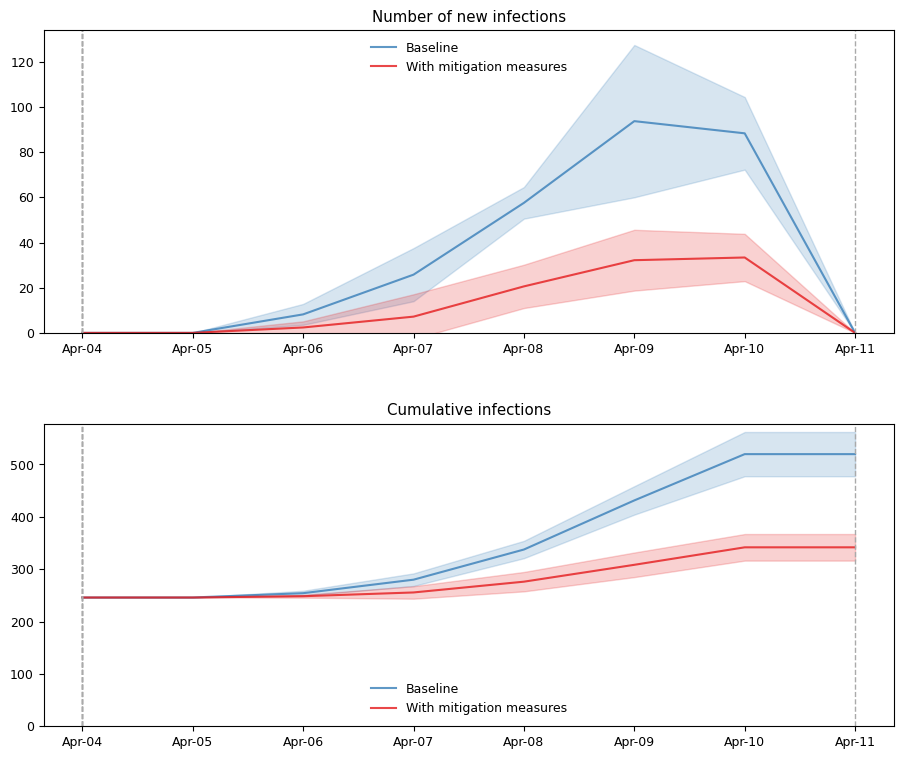

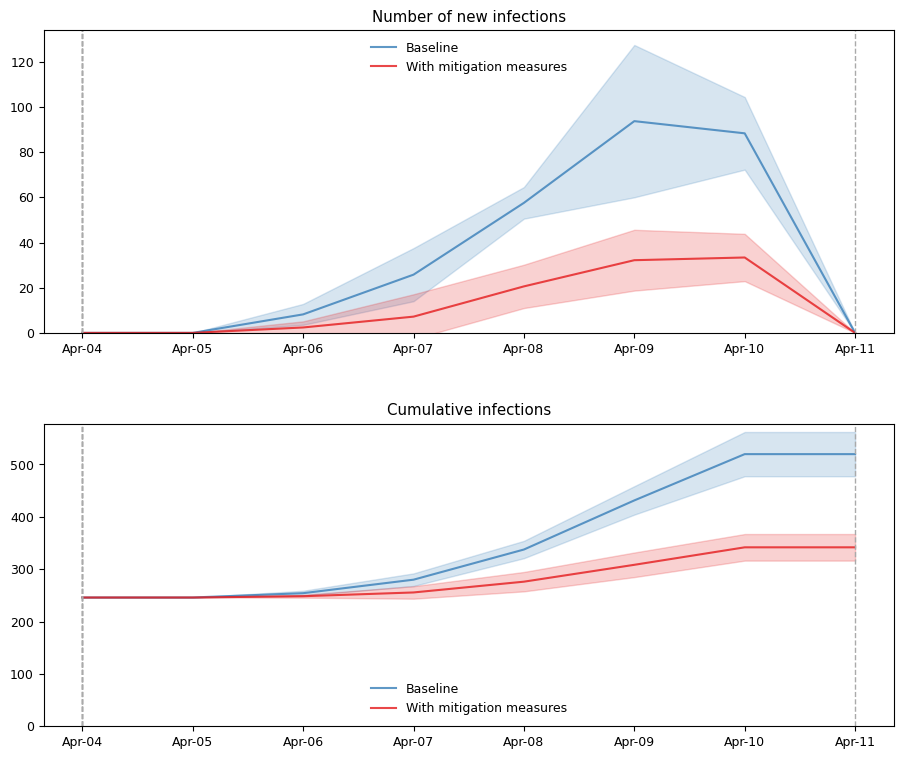

In [892]:
# RUN AND PLOT
msim = cv.MultiSim.merge(all_msims, base=True)
msim.plot(to_plot=['new_infections', 'cum_infections'],color_by_sim=True)